## BBC News Articles Classification Project

<div style="text-align:center">
<img src="https://github.com/milanfx/DTSA-5304/blob/main/image/kaggle.png?raw=true" alt="image description" width="800">
</div>

### 1. Peoject Description

Dataset Background: 
1. A public dataset from the BBC comprised of 2225 articles with label of 5 categories: business, entertainment, politics, sport or tech.
2. The dataset is broken into 1490 records for training and 735 for testing. 

Project Goal: 
1. Build a model using the matrix factorization method to predict the test data labels and measure the performances of the model.
2. Build a model using the supervised learning method to predict the test data labels and measure the performances of the model.
3. Compare the result from both two models.

### 2. Exploratory Data Analysis

First, we will complete the data cleaning, checking for null values and duplicate values.

Second, we will examine the distribution of the dependent variable and the statistical data of the text.

Third, we will remove the stop_words and conduct TF-IDF transformation on the text data to give it data features for subsequent predictive analysis. TF-IDF is a method used to measure the importance of words in a text, which takes into account not only the frequency of occurrence of a word in the text, but also its frequency in the entire category. Hence, using TF-IDF method, we will be able to classify categories more easily by utilizing the existing text features. 

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import warnings

#### 2.1 Loading Data

In [45]:
train = pd.read_csv('BBC News Train.csv')
test = pd.read_csv('BBC News Test.csv')

In [46]:
train.shape

(1490, 3)

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [48]:
train.head(10)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


We are going to use 'Text' to predict 'Category'

#### 2.2 Checking Missing Value

In [49]:
train.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

There is no missing value.

#### 2.3 Checking Duplicates

In [50]:
duplicates = train.duplicated(subset=["Text"]).sum()
duplicates

50

In [51]:
train.drop_duplicates(subset=["Text"], inplace=True)
train.shape

(1440, 3)

There are 50 'Text' duplicates removed from train set.

#### 2.4 Checking Distribution

<AxesSubplot:xlabel='Category', ylabel='Count'>

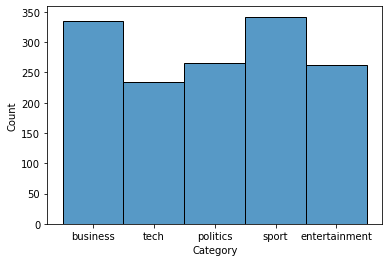

In [52]:
fig = plt.figure(figsize=(6, 4))
sns.histplot(train["Category"], bins=20)

The difference in the number of categories is not significant, so we will keep all of them.

#### 2.5 Checking Word Distribution

Total Word

Total World: 554711


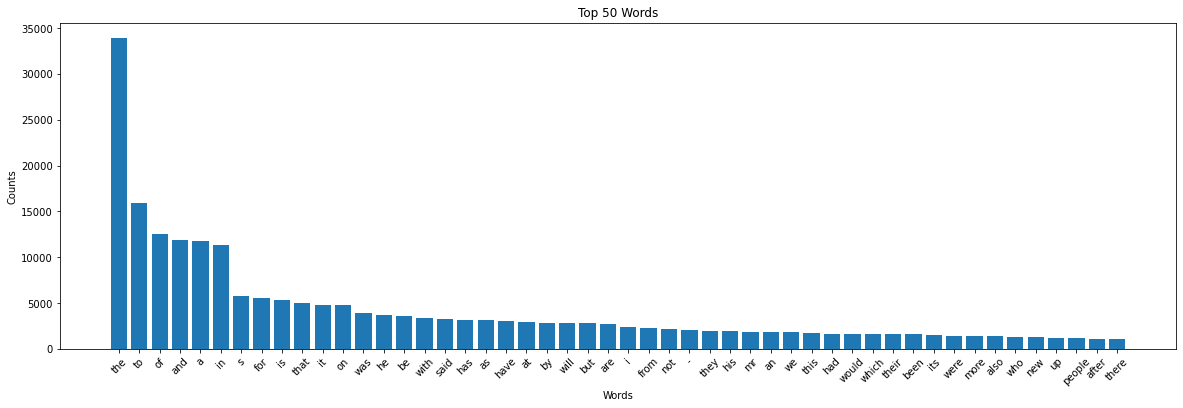

In [53]:
# Count Words
all_text = train['Text'].str.cat(sep=' ')
words = all_text.lower().split()
total_words = len(words)
print('Total World:', total_words)
word_counts = Counter(words)
top_words = word_counts.most_common(50)
words = [word[0] for word in top_words]
counts = [word[1] for word in top_words]
# Bar Chart
plt.figure(figsize=(20, 6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Top 50 Words')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()

Total Unique Word

In [54]:
unique_words = set()
categories = train['Category'].unique()

for cat in categories:
    text = train[train['Category'] == cat]['Text'].str.cat(sep=' ')
    words = text.lower().split()
    unique_words.update(words)

unique_words_counts = len(unique_words)
print("Total unique words: {}".format(unique_words_counts))

Total unique words: 35594


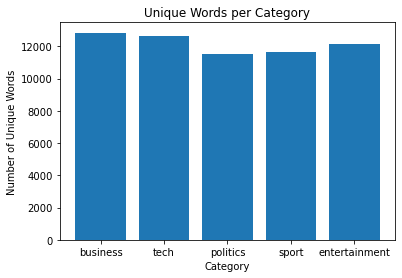

In [55]:
categories = train['Category'].unique()

for cat in categories:
    text = train[train['Category'] == cat]['Text'].str.cat(sep=' ')
    words = text.lower().split()
    unique_words = set(words)
    unique_word_counts = len(unique_words)
    category_word_counts = [len(train[train['Category'] == cat]['Text'].str.lower().str.split().explode().unique()) for cat in categories]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(categories, category_word_counts)
ax.set_xlabel('Category')
ax.set_ylabel('Number of Unique Words')
ax.set_title('Unique Words per Category')
plt.show()

#### 2.6 Checking Words Format

In [56]:
train.loc[0, 'Text']

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

In [57]:
train['Text'] = train['Text'].str.lower()

#### 2.7 TF-IDF Transformation

Find the best max_df and min_df, and also remove stop_words

In [60]:
tf = TfidfVectorizer(sublinear_tf=True,
                            max_df=0.8, #try 0.5, 0.7, 0.9
                            min_df=8, # try 6, 8, 10
                            stop_words="english")
tf.fit(train["Text"])
tf_train = tf.transform(train["Text"])
tf_test = tf.transform(test["Text"])
print(tf_train.shape)
print(tf_test.shape)

(1440, 4878)
(735, 4878)


Using a TF-IDF vectorizer to transform text data into numerical features.

### 3. Building Supervised Model

First, I will run Random Forest Classifier Model with the best hyperparameters.

Then, I will run Logistic Regression and compare the result with Random Forest Classifier.

Lastly, I will choose the better model to see if the model is data-efficient.

#### 3.1 Random Forest Classifier Model

In [61]:
X_train, X_valid, y_train, y_valid = train_test_split(tf_train, train['Category'], test_size=0.3, random_state=26)

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100}
Validation Accuracy: 0.8981481481481481


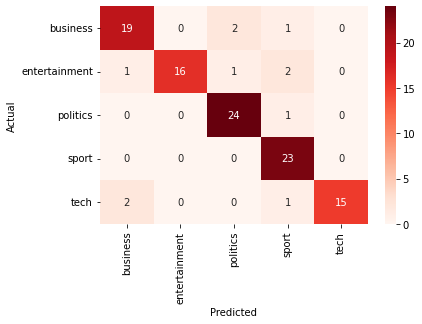

In [71]:
rf = RandomForestClassifier(random_state=26)
# hyper
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}
# grid search
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_valid)
# best params
print('Best parameters:', grid_search.best_params_)
print('Validation Accuracy:', accuracy_score(y_valid, y_pred))

cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', xticklabels=grid_search.classes_, yticklabels=grid_search.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

y_test_pred = grid_search.predict(tf_test)
output = pd.DataFrame({'ArticleId': test['ArticleId'], 'Category': y_test_pred})
output.to_csv('rf100.csv', index=False)

#### 3.2 Logistic Regression with 100% Lables:

Logistic Regression Model perform much better than Random Forest Classifier Model on this data set

Validation Accuracy: 0.9652777777777778


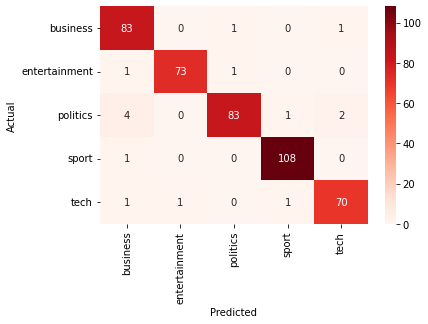

In [62]:
lr = LogisticRegression(random_state=26)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_valid)
acc = accuracy_score(y_valid, y_pred)
print("Validation Accuracy:", acc)
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
y_test_pred = lr.predict(tf_test)
# Save
output = pd.DataFrame({'ArticleId': test['ArticleId'], 'Category': y_test_pred})
output.to_csv('lr100.csv', index=False)

#### 3.3 Logistic Regression with 75% Lables:

In [63]:
train_75 = train.sample(frac=0.75, random_state=26)
tf = TfidfVectorizer(sublinear_tf=True,
                            max_df=0.8, #try 0.5, 0.7, 0.9
                            min_df=8, # try 6, 8, 10
                            stop_words="english")
tf.fit(train_75["Text"])
tf_train = tf.transform(train_75["Text"])
tf_test = tf.transform(test["Text"])
X_train, X_valid, y_train, y_valid = train_test_split(tf_train, train_75['Category'], test_size=0.3, random_state=26)

Validation Accuracy: 0.9475308641975309


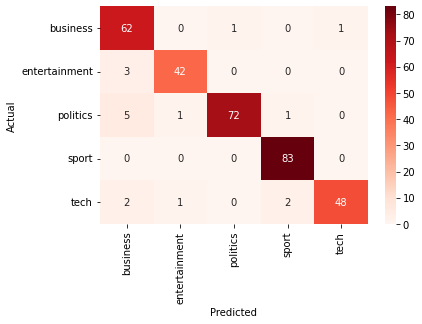

In [64]:
lr = LogisticRegression(random_state=26)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_valid)
acc = accuracy_score(y_valid, y_pred)
print("Validation Accuracy:", acc)
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
y_test_pred = lr.predict(tf_test)
# Save
output = pd.DataFrame({'ArticleId': test['ArticleId'], 'Category': y_test_pred})
output.to_csv('lr75.csv', index=False)

#### 3.4 Logistic Regression with 50% Lables:

In [65]:
train_50 = train.sample(frac=0.50, random_state=26)
tf = TfidfVectorizer(sublinear_tf=True,
                            max_df=0.8, #try 0.5, 0.7, 0.9
                            min_df=8, # try 6, 8, 10
                            stop_words="english")
tf.fit(train_50["Text"])
tf_train = tf.transform(train_50["Text"])
tf_test = tf.transform(test["Text"])
X_train, X_valid, y_train, y_valid = train_test_split(tf_train, train_50['Category'], test_size=0.3, random_state=26)

Validation Accuracy: 0.9490740740740741


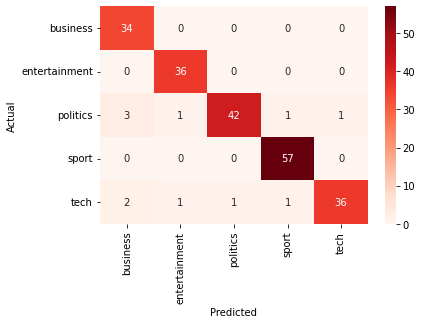

In [66]:
lr = LogisticRegression(random_state=26)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_valid)
acc = accuracy_score(y_valid, y_pred)
print("Validation Accuracy:", acc)
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
y_test_pred = lr.predict(tf_test)
# Save
output = pd.DataFrame({'ArticleId': test['ArticleId'], 'Category': y_test_pred})
output.to_csv('lr50.csv', index=False)

#### 3.5 Logistic Regression with 25% Lables:

In [67]:
train_25 = train.sample(frac=0.25, random_state=26)
tf = TfidfVectorizer(sublinear_tf=True,
                            max_df=0.8, #try 0.5, 0.7, 0.9
                            min_df=8, # try 6, 8, 10
                            stop_words="english")
tf.fit(train_25["Text"])
tf_train = tf.transform(train_25["Text"])
tf_test = tf.transform(test["Text"])
X_train, X_valid, y_train, y_valid = train_test_split(tf_train, train_25['Category'], test_size=0.3, random_state=26)

Validation Accuracy: 0.9722222222222222


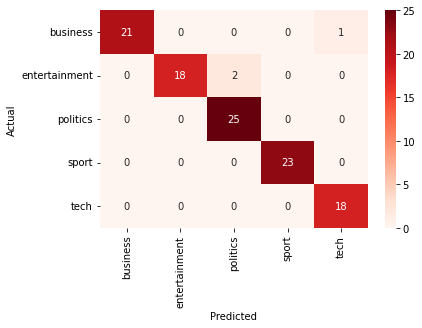

In [68]:
lr = LogisticRegression(random_state=26)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_valid)
acc = accuracy_score(y_valid, y_pred)
print("Validation Accuracy:", acc)
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
y_test_pred = lr.predict(tf_test)
# Save
output = pd.DataFrame({'ArticleId': test['ArticleId'], 'Category': y_test_pred})
output.to_csv('lr25.csv', index=False)

<div style="text-align:center">
<img src="https://github.com/milanfx/DTSA-5304/blob/main/image/Logistic%20Regression.png?raw=true" alt="image description" width="800">
</div>

-----Logistic Regression Model Score: 0.98231(100%), 0.97551(75%), 0.95918(50%), 0.94149(25%)-----

1. The Logistic Regression achieves an accuracy of over 98% on the entire dataset.

2. On a 25% sample, the score is over 94%, indicating that it is very data-efficient. 

3. In addition, there is no overfitting in Logistic Regression.

### 4. Building Unsupervised Model

First, I will find the best hyperparameters for Non-negative Matrix Facorization Model.

Then, I will test its performance on different scope of data size.

Lastly, I will compare the results with those from Logistic Regression.

#### 4.1 Non-negative Matrix Facorization Model Tuning Hyperparameters

In [105]:
tf = TfidfVectorizer(sublinear_tf=True,
                     max_df=0.8,
                     min_df=8,
                     stop_words='english')
tf.fit(train['Text'])
tf_train = tf.transform(train['Text'])
tf_test = tf.transform(test['Text'])

nmf = NMF(train['Category'].nunique(),
          init = 'nndsvda',
          random_state= 0,                  ##'random' 'nndsvd ' 'nndsvda' 'nndsvdar' 'custom'
          beta_loss = 'kullback-leibler',   ## 'frobenius' 'kullback-leibler'  'itakura-saito'
          solver = 'mu',                     ## 'mu'  , 'cd'
          max_iter = 200,        
          alpha_W = 0.0001)                   ## 0.0001 0.001 , 0.005, 0.01
         
nmf.fit(tf_train)
y_pred = np.array([np.argmax(i) for i in nmf.transform(tf_train)])
y_true = np.array(train.Category).reshape(-1)
uni_labels = np.unique(y_true)
best_perm = None
best_acc = 0
for i, label in enumerate(uni_labels):
    for perm in itertools.permutations(range(len(uni_labels))):
        perm_label_map = {label: int_label for label, int_label in zip(uni_labels, perm)}
        perm_labels = np.array([perm_label_map[label] for label in y_true])
        acc = np.mean(perm_labels == y_pred)
        if acc > best_acc:
            best_perm = {num: l for num, l in zip(perm, uni_labels)}
            best_acc = acc
print('Train Accuracy:', best_acc)

Train Accuracy: 0.9583333333333334


The Best Parameters is init = 'nndsvda',beta_loss = 'kullback-leibler',solver = 'mu',  max_iter = 200,alpha_W = 0.0001)

The Best Performance on training set is 0.9583333333333334

#### 4.2 Non-negative Matrix Facorization Model with 100% Lables:

In [155]:
tf = TfidfVectorizer(sublinear_tf=True,
                     max_df=0.8,
                     min_df=8,
                     stop_words='english')
tf.fit(train['Text'])
tf_train = tf.transform(train['Text'])
tf_test = tf.transform(test['Text'])
nmf = NMF(train['Category'].nunique(), random_state=0, init = 'nndsvda',beta_loss = 'kullback-leibler',
          solver = 'mu', max_iter = 200,alpha_W = 0.0001)
         
nmf.fit(tf_train)
y_pred = np.array([np.argmax(i) for i in nmf.transform(tf_train)])
y_true = np.array(train.Category).reshape(-1)
uni_labels = np.unique(y_true)
best_perm = None
best_acc = 0
for i, label in enumerate(uni_labels):
    for perm in itertools.permutations(range(len(uni_labels))):
        perm_label_map = {label: int_label for label, int_label in zip(uni_labels, perm)}
        perm_labels = np.array([perm_label_map[label] for label in y_true])
        acc = np.mean(perm_labels == y_pred)
        if acc > best_acc:
            best_perm = {num: l for num, l in zip(perm, uni_labels)}
            best_acc = acc
print('Train Accuracy:', best_acc)

y_pred = np.array([np.argmax(i) for i in nmf.transform(tf_test)])
nmf100 = pd.DataFrame(columns=['ArticleId', 'Category'])
nmf100['ArticleId'] = test.ArticleId
nmf100['Category'] = [best_perm[i] for i in y_pred]
nmf100.to_csv('nmf100.csv', index=False)

Train Accuracy: 0.9583333333333334


Accuracy on Kaggle: 0.94285

#### 4.3 Non-negative Matrix Facorization Model with 75% Lables:

In [102]:
train_75 = train.sample(frac=0.75, random_state=26)
tf = TfidfVectorizer(sublinear_tf=True,
                     max_df=0.8,
                     min_df=8,
                     stop_words='english')
tf.fit(train_75['Text'])
tf_train = tf.transform(train_75['Text'])
tf_test = tf.transform(test['Text'])

nmf = NMF(train_75['Category'].nunique(), random_state=0)
nmf.fit(tf_train)
y_pred = np.array([np.argmax(i) for i in nmf.transform(tf_train)])
y_true = np.array(train_75.Category).reshape(-1)
uni_labels = np.unique(y_true)
best_perm = None
best_acc = 0
for i, label in enumerate(uni_labels):
    for perm in itertools.permutations(range(len(uni_labels))):
        perm_label_map = {label: int_label for label, int_label in zip(uni_labels, perm)}
        perm_labels = np.array([perm_label_map[label] for label in y_true])
        acc = np.mean(perm_labels == y_pred)
        if acc > best_acc:
            best_perm = {num: l for num, l in zip(perm, uni_labels)}
            best_acc = acc
print('Train Accuracy:', best_acc)

y_pred = np.array([np.argmax(i) for i in nmf.transform(tf_test)])
nmf75 = pd.DataFrame(columns=['ArticleId', 'Category'])
nmf75['ArticleId'] = test.ArticleId
nmf75['Category'] = [best_perm[i] for i in y_pred]
nmf75.to_csv('nmf75.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Train Accuracy: 0.9407407407407408


Accuracy on Kaggle: 0.94285

#### 4.4 Non-negative Matrix Facorization Model with 50% Lables:

In [103]:
train_50 = train.sample(frac=0.5, random_state=26)
tf = TfidfVectorizer(sublinear_tf=True,
                     max_df=0.8,
                     min_df=8,
                     stop_words='english')
tf.fit(train_50['Text'])
tf_train = tf.transform(train_50['Text'])
tf_test = tf.transform(test['Text'])

nmf = NMF(train_50['Category'].nunique(), random_state=0)
nmf.fit(tf_train)
y_pred = np.array([np.argmax(i) for i in nmf.transform(tf_train)])
y_true = np.array(train_50.Category).reshape(-1)
uni_labels = np.unique(y_true)
best_perm = None
best_acc = 0
for i, label in enumerate(uni_labels):
    for perm in itertools.permutations(range(len(uni_labels))):
        perm_label_map = {label: int_label for label, int_label in zip(uni_labels, perm)}
        perm_labels = np.array([perm_label_map[label] for label in y_true])
        acc = np.mean(perm_labels == y_pred)
        if acc > best_acc:
            best_perm = {num: l for num, l in zip(perm, uni_labels)}
            best_acc = acc
print('Train Accuracy:', best_acc)

y_pred = np.array([np.argmax(i) for i in nmf.transform(tf_test)])
nmf50 = pd.DataFrame(columns=['ArticleId', 'Category'])
nmf50['ArticleId'] = test.ArticleId
nmf50['Category'] = [best_perm[i] for i in y_pred]
nmf50.to_csv('nmf50.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Train Accuracy: 0.9472222222222222


Accuracy on Kaggle: 0.94557

#### 4.5 Non-negative Matrix Facorization Model with 25% Lables:

In [104]:
train_25 = train.sample(frac=0.25, random_state=26)
tf = TfidfVectorizer(sublinear_tf=True,
                     max_df=0.8,
                     min_df=8,
                     stop_words='english')
tf.fit(train_25['Text'])
tf_train = tf.transform(train_25['Text'])
tf_test = tf.transform(test['Text'])

nmf = NMF(train_25['Category'].nunique(), random_state=0)
nmf.fit(tf_train)
y_pred = np.array([np.argmax(i) for i in nmf.transform(tf_train)])
y_true = np.array(train_25.Category).reshape(-1)
uni_labels = np.unique(y_true)
best_perm = None
best_acc = 0
for i, label in enumerate(uni_labels):
    for perm in itertools.permutations(range(len(uni_labels))):
        perm_label_map = {label: int_label for label, int_label in zip(uni_labels, perm)}
        perm_labels = np.array([perm_label_map[label] for label in y_true])
        acc = np.mean(perm_labels == y_pred)
        if acc > best_acc:
            best_perm = {num: l for num, l in zip(perm, uni_labels)}
            best_acc = acc
print('Train Accuracy:', best_acc)

y_pred = np.array([np.argmax(i) for i in nmf.transform(tf_test)])
nmf25 = pd.DataFrame(columns=['ArticleId', 'Category'])
nmf25['ArticleId'] = test.ArticleId
nmf25['Category'] = [best_perm[i] for i in y_pred]
nmf25.to_csv('nmf25.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Train Accuracy: 0.9444444444444444


Accuracy on Kaggle: 0.94829

<div style="text-align:center">
<img src="https://github.com/milanfx/DTSA-5304/blob/main/image/NMF.png?raw=true" alt="image description" width="800">
</div>

-----Non-negative Matrix Facorization Model: 0.94285(100%), 0.94285(75%), 0.94557(50%), 0.94829(25%)-----

1. The Non-negative Matrix Facorization Model achieves an accuracy of over 94% on the entire dataset.

2. From 25% sample to 100%, the score maintains at 94%, indicating that the model is stable and very data-efficient. 

3. In addition, there is no overfitting in Non-negative Matrix Facorization Model.

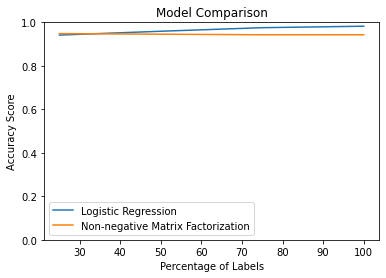

In [160]:
import matplotlib.pyplot as plt

# Model scores
lr_scores = [0.98231, 0.97551, 0.95918, 0.94149]
nmf_scores = [0.94285, 0.94285, 0.94557, 0.94829]

# Percentage of training data used
train_percentages = [100, 75, 50, 25]

# Plot the scores as two separate lines on the same graph
plt.plot(train_percentages, lr_scores, label='Logistic Regression')
plt.plot(train_percentages, nmf_scores, label='Non-negative Matrix Factorization')
plt.xlabel('Percentage of Labels')
plt.ylabel('Accuracy Score')
plt.title('Model Comparison')
plt.ylim(0, 1)
plt.legend()
plt.show()


### 5. Conclusion

In this project, we mainly used Logistic Regression model and Non-negative Matrix Facorization Model to predict the category of articles. Both two models performed very well, with prediction accuracy over 94%, and Logistic Regression had the highest score 98%.Both two models show very stable performance when we narrow down the lable scope, indicating they are both data-efficient.Besides, there is no overfitting signal.

Overall, the performance of unsupervised learning on this dataset is surprisingly good, surpassing the performance of Random Forest, which indicates that NMF has great advantages in analyzing language models. Since text data usually has a high-dimensional feature space and sparsity, NMF can reduce high-dimensional data to a low-dimensional space and extract key semantic features, which is very useful for tasks such as text classification and topic modeling.

Reference:

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.non_negative_factorization.html

https://www.geeksforgeeks.org/removing-stop-words-nltk-python/